# Предсказание риска сердечных приступов

**Цель исследования:**
- Создать модель для предсказания риска сердечных приступов

**Ход исследования:**
- Импорт данных;
- Предобработка данных;
- Исследование датасета;
- Обучение модели.

**Описание признаков**
| Признак | Описание |
|:--:|:--:|
| **Age** | Возраст (количественный, отмасштабирован) |
| **Cholesterol** | Холестерин в крови (количественный, отмасштабирован) |
| **Heart rate** | Частота сердечных сокращений (количественный, отмасштабирован) |
| **Diabetes** | Наличие диабета (категориальный) |
| **Family History** | История семьи (категориальный) |
| **Smoking** | Курит ли пациент (категориальный) |
| **Obesity** | Ожирение (категориальный) |
| **Alcohol Consumption** | Употребляет ли пациент алкоголь (категориальный) |
| **Exercise Hours Per Week** | Физическая активность, часов в неделю (количественный, отмасштабирован) |
| **Diet** | Диета (категориальный) |
| **Previous Heart Problems** | Наличие проблем с сердец в прошлом (категориальный) |
| **Medication Use** | Использует ли пациент лекарства (категориальный) |
| **Stress Level** | Уровень стресса (количественный дискретный) |
| **Sedentary Hours Per Day** | Количество часов в сидячем положении (количественный, отмасштабирован) |
| **Income** | Доход (количественный, отмасштабирован) |
| **BMI** | Индекс массы тела (количественный, отмасштабирован) |
| **Triglycerides** | Триглицериды (количественный, отмасштабирован) | 
| **Physical Activity Days Per Week** | Количество дней активности в неделю (количественный дискретный) |
| **Sleep Hours Per Day** | Количество часов сна в день (количественный дискретный) |
| **Heart Attack Risk (Binary)** | Риск сердечного приступа (категориальный, **целевой признак**) |
| **Blood sugar** | Сахар в крови (количественный, отмасштабирован) | 
| **CK-MB** | Креатинкиназа МВ (количественный, отмасштабирован) | 
| **Troponin** | Тропонин (количественный, отмасштабирован) | 
| **Gender** | Пол (категориальный) |
| **Systolic blood pressure** | Систолическое артериальное давление (количественный, отмасштабирован) |
| **Diastolic blood pressure** | Диастолическое артериальное давление (количественный, отмасштабирован) |
| **id** | Уникальный идентификатор пациента |

## Импорт библиотек

In [191]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import simplefilter
simplefilter(action='ignore')

pd.set_option('display.float_format', '{:,.2f}'.format)
RANDOM_STATE = 42

## Загрузка данных

In [192]:
pth1 = 'heart_train.csv'

In [193]:
if os.path.exists(pth1):
    train_df = pd.read_csv(pth1)
else:
    print('Упс, что-то пошло не так!')
                                         
train_df.head()

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.36,0.73,0.07,1.00,1.00,1.00,1.00,1.00,0.54,...,3.00,0.33,0.00,0.23,0.05,0.04,Male,0.21,0.71,2664
1,1,0.20,0.33,0.05,1.00,1.00,0.00,0.00,1.00,0.07,...,3.00,0.83,0.00,0.15,0.02,0.00,Female,0.41,0.57,9287
2,2,0.61,0.86,0.06,1.00,0.00,1.00,1.00,1.00,0.94,...,2.00,1.00,0.00,0.23,0.05,0.04,Female,0.24,0.22,5379
3,3,0.73,0.01,0.05,0.00,0.00,1.00,0.00,1.00,0.70,...,0.00,0.33,1.00,0.23,0.05,0.04,Female,0.35,0.27,8222
4,4,0.78,0.76,0.02,0.00,0.00,1.00,0.00,1.00,0.41,...,5.00,1.00,1.00,0.23,0.05,0.04,Male,0.62,0.44,4047


In [194]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 28 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use      

In [195]:
# Составим списки для количественных и категориальных признаков
numerical_features = [
    'Age',
    'Cholesterol',
    'Heart rate',
    'Exercise Hours Per Week',
    'Stress Level', # дискретный
    'Sedentary Hours Per Day',
    'Income',
    'BMI',
    'Triglycerides',
    'Physical Activity Days Per Week',  # дискретный
    'Sleep Hours Per Day',  # дискретный
    'Blood sugar',
    'CK-MB',
    'Troponin',
    'Systolic blood pressure',
    'Diastolic blood pressure'
]

categorical_features = [
    'Diabetes',
    'Family History',
    'Smoking',
    'Obesity',
    'Alcohol Consumption',
    'Diet',
    'Previous Heart Problems',
    'Medication Use',
    'Heart Attack Risk (Binary)',
    'Gender'
]

Вывод
- В датафрейме 8685 строк;
- Есть пропуски;

## Предобработка данных

### Удаление признака "Unnamed: 0"

In [196]:
train_df.drop('Unnamed: 0', axis=1, inplace=True)
train_df.columns

Index(['Age', 'Cholesterol', 'Heart rate', 'Diabetes', 'Family History',
       'Smoking', 'Obesity', 'Alcohol Consumption', 'Exercise Hours Per Week',
       'Diet', 'Previous Heart Problems', 'Medication Use', 'Stress Level',
       'Sedentary Hours Per Day', 'Income', 'BMI', 'Triglycerides',
       'Physical Activity Days Per Week', 'Sleep Hours Per Day',
       'Heart Attack Risk (Binary)', 'Blood sugar', 'CK-MB', 'Troponin',
       'Gender', 'Systolic blood pressure', 'Diastolic blood pressure', 'id'],
      dtype='object')

### Обработка дубликатов

#### Проверка явных дубликатов

In [197]:
train_df.duplicated().sum()

0

#### Проверка неявных дубликатов

In [198]:
# Поиск дубликатов по ID
train_df['id'].duplicated().sum()

0

In [199]:
# Поиск дубликатов по всем признакам, за исключение признака ID
train_df.drop('id', axis=1).duplicated().sum()

0

### Обработка пропусков

In [200]:
# Заполним пропуску для категориальных признаков модой, а для числовых признаков медианой
for column in train_df.columns:
    if train_df[column].dtype == 'object':
        train_df[column] = train_df[column].fillna(train_df[column].mode()[0])
    else:
        train_df[column] = train_df[column].fillna(train_df[column].median())

In [201]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8685 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8685 non-null   float64
 4   Family History                   8685 non-null   float64
 5   Smoking                          8685 non-null   float64
 6   Obesity                          8685 non-null   float64
 7   Alcohol Consumption              8685 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8685 non-null   float64
 11  Medication Use                   8685 non-null   float64
 12  Stress Level        

### Обработка выбросов

In [202]:
def statistics_for_num(feature):
    # Расчет количество выбросов
    q1 = train_df[feature].quantile(0.25)
    q3 = train_df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = train_df[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)]
    
    print(f"Признак - {feature}")
    print(f"Количество выбросов: {len(outliers)}")
    print()

In [203]:
for feature in numerical_features:
    statistics_for_num(feature)

Признак - Age
Количество выбросов: 0

Признак - Cholesterol
Количество выбросов: 0

Признак - Heart rate
Количество выбросов: 2

Признак - Exercise Hours Per Week
Количество выбросов: 0

Признак - Stress Level
Количество выбросов: 0

Признак - Sedentary Hours Per Day
Количество выбросов: 0

Признак - Income
Количество выбросов: 0

Признак - BMI
Количество выбросов: 0

Признак - Triglycerides
Количество выбросов: 0

Признак - Physical Activity Days Per Week
Количество выбросов: 0

Признак - Sleep Hours Per Day
Количество выбросов: 0

Признак - Blood sugar
Количество выбросов: 2134

Признак - CK-MB
Количество выбросов: 2134

Признак - Troponin
Количество выбросов: 2134

Признак - Systolic blood pressure
Количество выбросов: 0



In [204]:
# Выявим выбросы в признаке 'Heart rate'
train_df[train_df['Heart rate'] == 1]

,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,Diet,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
1377,0.63,0.50,1.00,1.00,0.00,1.00,0.00,1.00,0.50,3,...,3.00,0.50,0.00,0.20,0.01,0.00,0.0,0.49,0.62,9547
2712,0.20,0.50,1.00,1.00,0.00,1.00,0.00,1.00,0.50,3,...,3.00,0.50,0.00,0.09,0.01,0.00,0.0,0.49,0.62,9611


In [205]:
# Удалим выбросы в признаке 'Heart rate'
train_df = train_df[train_df['Heart rate'] != 1]

In [206]:
statistics_for_num('Heart rate')

Признак - Heart rate
Количество выбросов: 0



Вывод по подразделу "Обработка выбросов":
- Выполнено удаление выбросов признаке **"Heart rate"**
- Для остальных признаков, количество выбросов составляет значительную часть датасеты, и их удаление невозможно.

### Исправление данных в признаке "Gender"

In [207]:
# Отобразим количество по категориям
train_df['Gender'].value_counts()

Gender
Male      5882
Female    2560
1.0        156
0.0         85
Name: count, dtype: int64

In [208]:
# исправим 1 на Male и 0 на Female с учетом распределение по обеим видам категорий
train_df['Gender'].replace('1.0', 'Male', inplace=True)
train_df['Gender'].replace('0.0', 'Female', inplace=True)

# Проверим результат
train_df['Gender'].value_counts()

Gender
Male      6038
Female    2645
Name: count, dtype: int64

Вывод по подразделу 'Исправление данных в признаке "Gender"':
- Исправлены данные:
    - '1.0' на 'Male'
    - '0.0' на Female'

### Приведение типов

In [209]:
# преобразуем тип данных для категориальных признаков к int64
for feat in categorical_features:
    if train_df[feat].dtype == 'float64':
        train_df[feat] = train_df[feat].astype('int64')

# Результат приведения типов к int64
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8683 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8683 non-null   float64
 1   Cholesterol                      8683 non-null   float64
 2   Heart rate                       8683 non-null   float64
 3   Diabetes                         8683 non-null   int64  
 4   Family History                   8683 non-null   int64  
 5   Smoking                          8683 non-null   int64  
 6   Obesity                          8683 non-null   int64  
 7   Alcohol Consumption              8683 non-null   int64  
 8   Exercise Hours Per Week          8683 non-null   float64
 9   Diet                             8683 non-null   int64  
 10  Previous Heart Problems          8683 non-null   int64  
 11  Medication Use                   8683 non-null   int64  
 12  Stress Level             

Вывод по подразделу 'Приведение типов':
- Выполнено приведение, для категориальных признаков с типом *float64*, к типу *int64*

Вывод по разделу **"Предобработка данных"**:
- Удален признак **"Unnamed: 0"** как неинформативный;
- Дубликаты отсутствуют;
- Заполнены пропуски модой для категориальных признаков и медианой для числовых;
- Выполнено удаление выбросов признаке **"Heart rate"**;
- Исправлены данные в признаке Gender - заменены 1.0 и 0.0 на Male и Female соответственно;
- Выполнено приведение, для категориальных признаков с типом *float64*, к типу *int64*

## Исследовательский анализ

In [210]:
def visualize_categorical_feature(df, plot=None, feature = None, hue = None, title = None, xlabel = None, ylabel = None):
    """
    Визуализирует и анализирует категориальные признаки.
    
    :param df: DataFrame с данными
    :param feature: категориальных признак для анализа
    """
    counts = df[feature].value_counts()

    # График распределения
    plt.figure(figsize=(6, 6))
    
    if plot == None:
        plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140);
    else:
        sns.countplot(data=df,
                      x=feature,
                      hue=hue,
                      palette="summer",
                     order=df[feature].value_counts().index);
        if xlabel: plt.xlabel(xlabel)
        if ylabel: plt.ylabel(ylabel)
    if title:
        plt.title(f'{title}')
    else:
        plt.title(f'{feature}')
    plt.show()

    # Статистика
    print(f'Статистика для {feature}:')
    print(f'- Уникальные значения: {df[feature].nunique()}')
    print()
    print(f'- Мода: {df[feature].mode()[0]}')
    print()
    if hue == None:
        print(f'- Частота по категориям:\n{df[feature].value_counts()}')
        print()
        print(f'- Процентное соотношение:\n{df[feature].value_counts(normalize=True).round(2) * 100}')
    else:
        pivot_table = df.pivot_table(index=feature,
                              columns=hue,
                              values='id',
                              aggfunc='count',
                              fill_value=0)

        # Расчет пропорций
        pivot_table_proportion = pivot_table.div(len(df))

        # Объединение данных
        final_table = pd.concat([pivot_table, pivot_table_proportion], axis=1, keys=['Count', 'Proportion'])
        return final_table

In [256]:
def visualize_numerical_feature(df, feature = None, xlabel = None, title = None, bins = 30, hue=None):
    """
    Создает комбинированный график, состоящий из 
    - боксплотта и гистограммы для количественного признака
    - countplot для дискретного признака.

    Параметры:
    - df: DataFrame, содержащий данные для визуализации.
    - feature: str, название признака для построения графиков.
    - xlabel: str, метка для оси X (по умолчанию None).
    - bins: int, количество корзин для гистограммы (по умолчанию 50).
    - hue: str, bool, добавляет в график разбиение по признаку(str=feature) или всем категориальным признакам (hue=True), 
    количество уникальных значений не более 5

    Возвращаемое значение: Отображает статистические данные и выводит графики на экран.
    """
    
    # Сформируем список категориальных признаков, 
    # где количество уникальных значений меньше лиибо равно 5 (чтобы не перегружать график)
    cat_features = [feat for feat in df.columns if df[feat].dtype == 'object' and df[feat].nunique() <=6]

    # Статистические данные
    uniq = df[feature].nunique()
    mean = df[feature].mean()
    median = df[feature].median()
    std = df[feature].std()
    min_val = df[feature].min()
    max_val = df[feature].max()
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    
    print(f"Статистики для {feature}:")
    print(f"Уникальных значений: {uniq:.0f}")
    print(f"Среднее: {mean:.2f}")
    print(f"Медиана: {median:.2f}")
    print(f"Стандартное отклонение: {std:.2f}")
    print(f"Минимум: {min_val:.2f}")
    print(f"Максимум: {max_val:.2f}")
    
    # Визуализация
    sns.set(font_scale=1)
    
    # График для дискретных значений
    if uniq <= 20:
        if hue == None or isinstance(hue, str):
            plt.figure(figsize = (10, 5))
            sns.countplot(data=df, 
                         x=feature,
                         color='skyblue', 
                         edgecolor='black',
                         hue=hue)
            plt.axvline(x=mean-min_val, color='b', ls='--', lw=2, label='Mean')
            plt.axvline(x=median-min_val, color='r', label='Median')
            plt.legend()
            plt.xticks(rotation=45)
            if title: plt.title(title)
            if xlabel: plt.xlabel(xlabel)
            plt.show()

            '''
            # Графики с разделением по категориальным признакам
            fig, axes = plt.subplots(nrows=len(cat_features),
                                     ncols= 1,
                                     figsize=(14, 18))
            axes =axes.flatten()
            
            for index, feat in enumerate(cat_features):
                handles = []
                labels = []
                ax = axes[index]

                hist = sns.countplot(data=df, 
                             x=feature, 
                             color='skyblue', 
                             edgecolor='black',
                             hue=feat,
                             ax=ax)


                for cat in df[feat].unique():
                    mean_value = df[df[feat] == cat][feature].mean()
                    line_handle = ax.axvline(x=mean_value-min_val, 
                                             color=f'#{random.randint(0, 0xFFFFFF):06x}',
                                             ls='--', 
                                             lw=2)
                    handles.append(line_handle)
                    labels.append(f'Mean {feat}={cat}')

                ax.set_title(f'{title} по признаку {feat}')
                if xlabel: ax.set_xlabel(xlabel)

                ax.legend(handles, labels)

            plt.tight_layout()
'''
            
            plt.show()
            
    # График для количественных признаков
    else:
        print(f"Q1: {q1:.2f}")
        print(f"Q3: {q3:.2f}")
        print(f"Количество выбросов: {len(outliers)}")
        if hue == None or isinstance(hue, str):
            f2, (ax_box2, ax_hist2) = plt.subplots(2, 
                                                   sharex=True, 
                                                   gridspec_kw={"height_ratios": (.15, .85)}, 
                                                   figsize=(12,6))
            sns.boxplot(data=df,
                        x=feature,
                        color='skyblue',
                        ax=ax_box2)
            sns.histplot(data=df, 
                         x=feature,
                         ax=ax_hist2, 
                         color='skyblue', 
                         edgecolor='black',
                         bins=bins,
                         hue=hue,
                         multiple='stack',
                         legend=True,
                         kde=True)
            plt.axvline(x=mean, color='b', ls='--', lw=2, label='Mean')
            plt.axvline(x=median, color='r', label='Median')
            plt.legend()
            plt.xticks(rotation=45)
            if xlabel: ax_hist2.set(xlabel=xlabel)
            if title: ax_box2.set(title=title)
            plt.show()

        elif hue:
            # Основной график
            f2, (ax_box2, ax_hist2) = plt.subplots(2, 
                                                   sharex=True, 
                                                   gridspec_kw={"height_ratios": (.15, .85)}, 
                                                   figsize=(14, 6))

            sns.boxplot(data=df,
                    x=feature,
                    color='skyblue',
                    ax=ax_box2)
            viz_box_plot = False
            sns.histplot(data=df, 
                     x=feature,
                     ax=ax_hist2, 
                     color='skyblue', 
                     edgecolor='black',
                     bins=bins,
                     multiple='stack',
                     legend=True,
                     kde=True)
            plt.axvline(x=mean, color='b', ls='--', lw=2, label='Mean')
            plt.axvline(x=median, color='r', label='Median')
            plt.legend()
            plt.xticks(rotation=45)
            if xlabel: ax_hist2.set(xlabel=xlabel)
            if title: ax_box2.set(title=title)

            # Графики с разделением по категориальным признакам
            fig, axes = plt.subplots(nrows=len(cat_features),
                                     ncols= 1,
                                     figsize=(12, 18))
            axes = axes.flatten()

            for index, feat in enumerate(cat_features):
                handles = []
                labels = []
                ax = axes[index]

                hist = sns.histplot(data=df,
                                    x=feature,
                                    color='skyblue', 
                                    edgecolor='black',
                                    bins=bins,
                                    hue=feat,
                                    stat='density', 
                                    common_norm=False,
                                    multiple='stack',
                                    legend=True,
                                    ax=ax)


                for cat in df[feat].unique():
                    mean_value = df[df[feat] == cat][feature].mean()
                    line_handle = ax.axvline(x=mean_value, 
                                             color=f'#{random.randint(0, 0xFFFFFF):06x}',
                                             ls='--', 
                                             lw=2)
                    handles.append(line_handle)
                    labels.append(f'Mean {feat}={cat}')

                ax.set_title(f'{title} по признаку {feat}')
                if xlabel: ax.set_xlabel(xlabel)

                ax.legend(handles, labels)

            plt.tight_layout()
            plt.show()

In [250]:
def proportion_table(df, feature, hue):
    pivot_table = df.pivot_table(index=feature,
                                  columns=hue,
                                  values='id',
                                  aggfunc='count',
                                  fill_value=0)

    # Расчет пропорций
    pivot_table_proportion = pivot_table.div(len(df))

    # Обхединение данных
    final_table = pd.concat([pivot_table, pivot_table_proportion], axis=1, keys=['Count', 'Proportion'])
    return final_table

#### Количественный признак "Age"

Статистики для Age:
Уникальных значений: 77
Среднее: 0.45
Медиана: 0.46
Стандартное отклонение: 0.23
Минимум: 0.00
Максимум: 1.00
Q1: 0.26
Q3: 0.64
Количество выбросов: 0


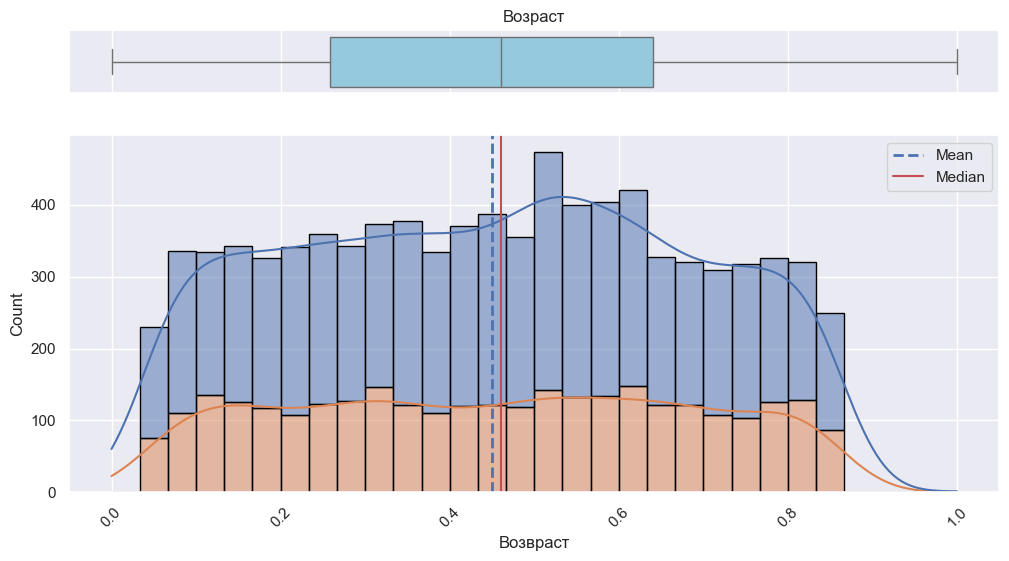

In [251]:
visualize_numerical_feature(df=train_df, 
                            feature='Age', 
                            bins = 30, 
                            title='Возраст', 
                            xlabel='Возвраст',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Age"**:
- Данные содержат возвраст;
- Данные отмасштабированны;
- Частота сердечных приступов, для всех возврастов, примерно одинакова.

#### Количественный признак "Cholesterol"

Статистики для Cholesterol:
Уникальных значений: 282
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.28
Минимум: 0.00
Максимум: 1.00
Q1: 0.27
Q3: 0.75
Количество выбросов: 0


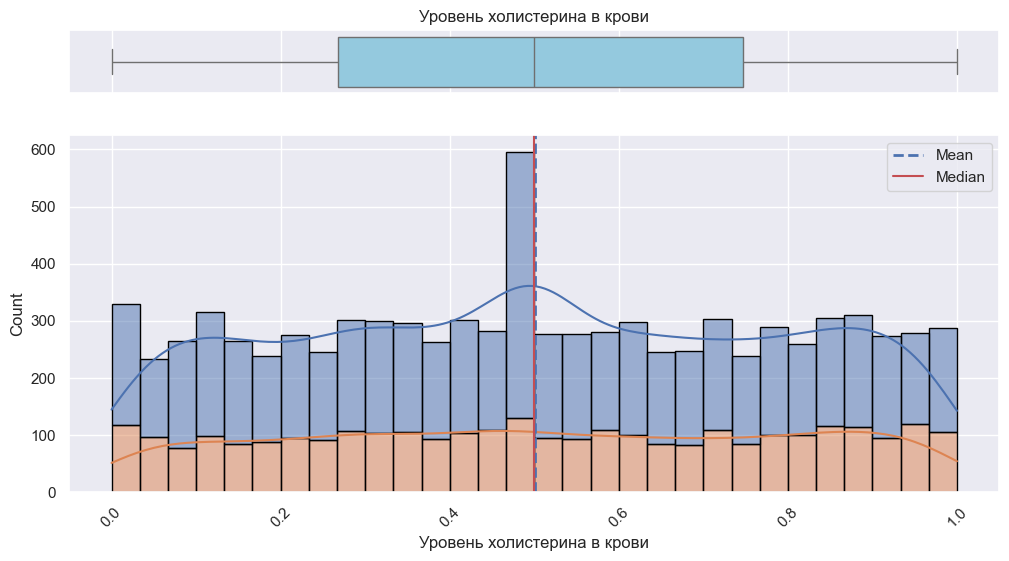

In [252]:
visualize_numerical_feature(df=train_df, 
                            feature='Cholesterol', 
                            bins = 30, 
                            title='Уровень холистерина в крови', 
                            xlabel='Уровень холистерина в крови',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Cholesterol"**:
- Данные уровень холистерина в крови;
- Данные отмасштабированны;
- Частота сердечных приступов, для всех значений холистерина, примерно одинакова.

#### Количественный признак "Heart rate"

Статистики для Heart rate:
Уникальных значений: 86
Среднее: 0.05
Медиана: 0.05
Стандартное отклонение: 0.02
Минимум: 0.00
Максимум: 0.11
Q1: 0.03
Q3: 0.07
Количество выбросов: 0


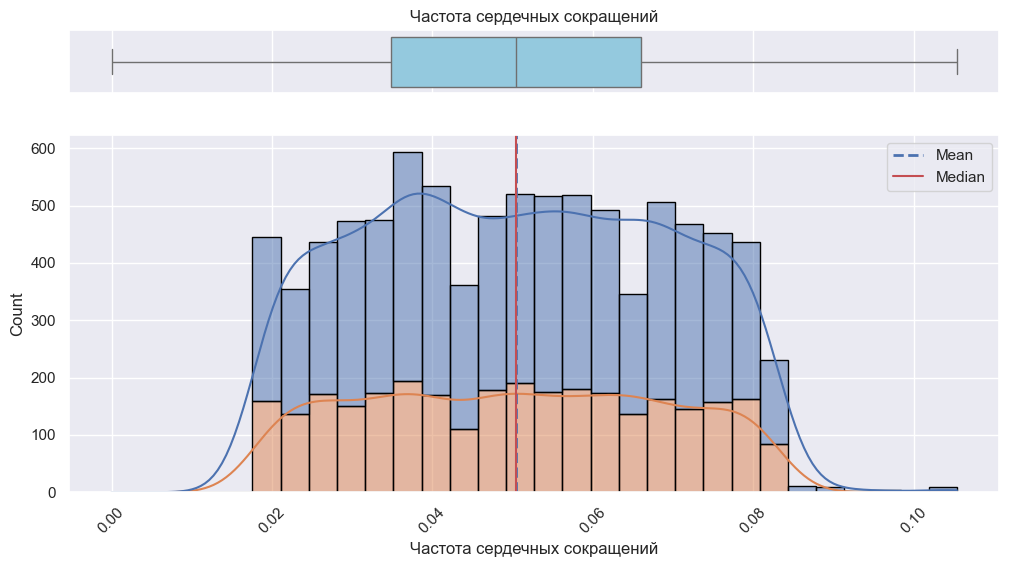

In [253]:
visualize_numerical_feature(df=train_df, 
                            feature='Heart rate', 
                            bins = 30, 
                            title='Частота сердечных сокращений', 
                            xlabel='Частота сердечных сокращений',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Heart rate"**:
- Данные отмасштабированны;
- Частота сердечных приступов, для всех значений частоты сердечных сокращений, примерно одинакова.

#### Количественный признак "Exercise Hours Per Week"

Статистики для Exercise Hours Per Week:
Уникальных значений: 7933
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.28
Минимум: 0.00
Максимум: 1.00
Q1: 0.26
Q3: 0.75
Количество выбросов: 0


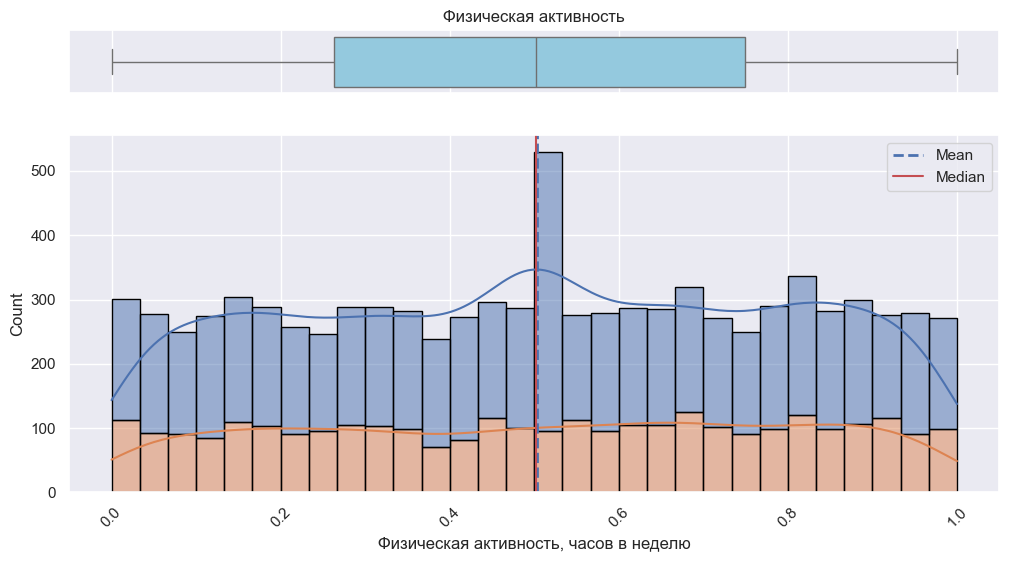

In [254]:
visualize_numerical_feature(df=train_df, 
                            feature='Exercise Hours Per Week', 
                            bins = 30, 
                            title='Физическая активность', 
                            xlabel='Физическая активность, часов в неделю',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Exercise Hours Per Week"**:
- Данные отмасштабированны;
- Для медианного значения физической активности, имеется пик отсутствия сердечных приступов - результат заполнения пропусков.

#### Дискретный признак "Stress Level"

Статистики для Stress Level:
Уникальных значений: 10
Среднее: 5.48
Медиана: 5.00
Стандартное отклонение: 2.83
Минимум: 1.00
Максимум: 10.00


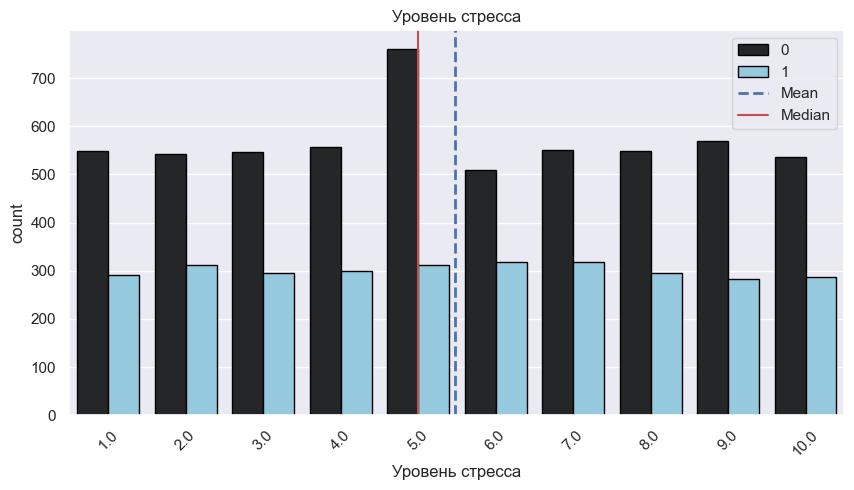

In [257]:
visualize_numerical_feature(df=train_df, 
                            feature='Stress Level',
                            title='Уровень стресса', 
                            xlabel='Уровень стресса',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Stress Level"**:
- Для медианного значения уровня стресса = 5, наблюдается пик отсутствия сердечных приступов - результат заполнения пропусков.

#### Количественный признак "Sedentary Hours Per Day"

Статистики для Sedentary Hours Per Day:
Уникальных значений: 7933
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.29
Минимум: 0.00
Максимум: 1.00
Q1: 0.26
Q3: 0.74
Количество выбросов: 0


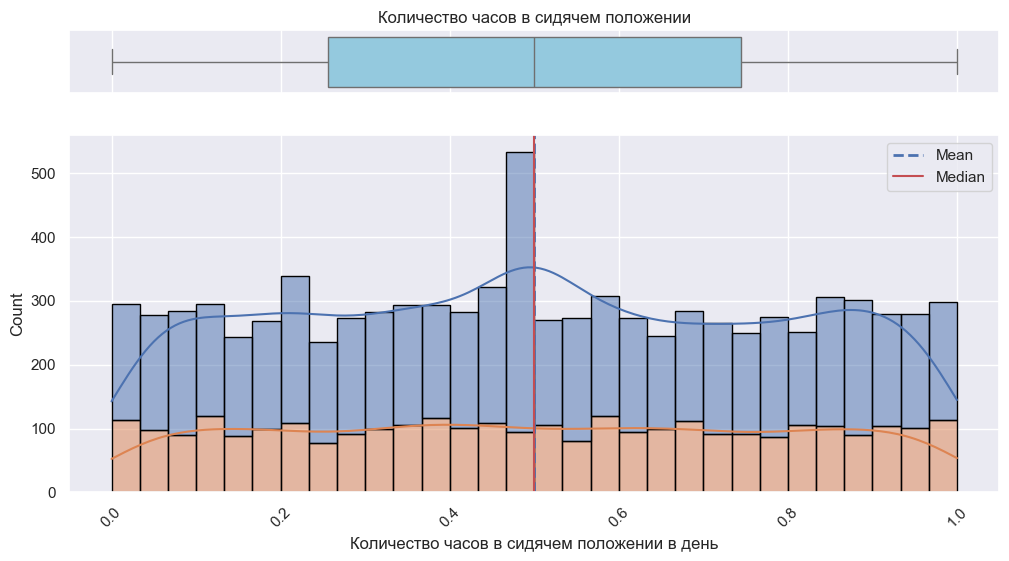

In [265]:
visualize_numerical_feature(df=train_df, 
                            feature='Sedentary Hours Per Day', 
                            bins = 30, 
                            title='Количество часов в сидячем положении', 
                            xlabel='Количество часов в сидячем положении в день',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Sedentary Hours Per Day"**:
- Данные отмасштабированны;
- Для медианного значения количества часов в сидячем положении = 0,5, наблюдается пик отсутствия сердечных приступов - результат заполнения пропусков.

#### Количественный признак "Income"

Статистики для Income:
Уникальных значений: 7808
Среднее: 0.50
Медиана: 0.49
Стандартное отклонение: 0.28
Минимум: 0.00
Максимум: 1.00
Q1: 0.25
Q3: 0.74
Количество выбросов: 0


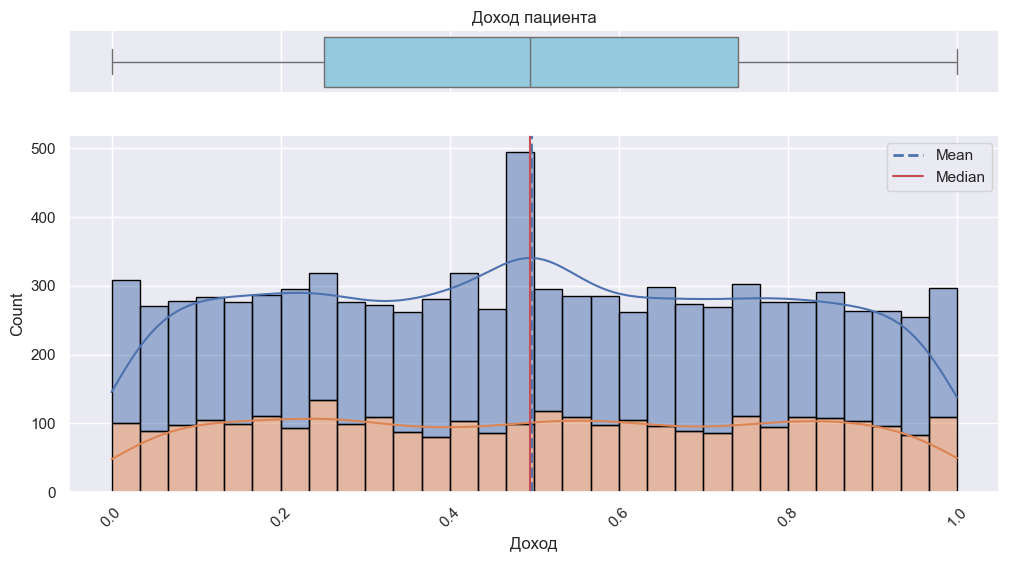

In [266]:
visualize_numerical_feature(df=train_df, 
                            feature='Income', 
                            bins = 30, 
                            title='Доход пациента', 
                            xlabel='Доход',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Income"**:
- Данные отмасштабированны;
- Для медианного значения дохода, наблюдается пик отсутствия сердечных приступов  - результат заполнения пропусков.

#### Количественный признак "BMI"

Статистики для BMI:
Уникальных значений: 7933
Среднее: 0.50
Медиана: 0.49
Стандартное отклонение: 0.28
Минимум: 0.00
Максимум: 1.00
Q1: 0.25
Q3: 0.74
Количество выбросов: 0


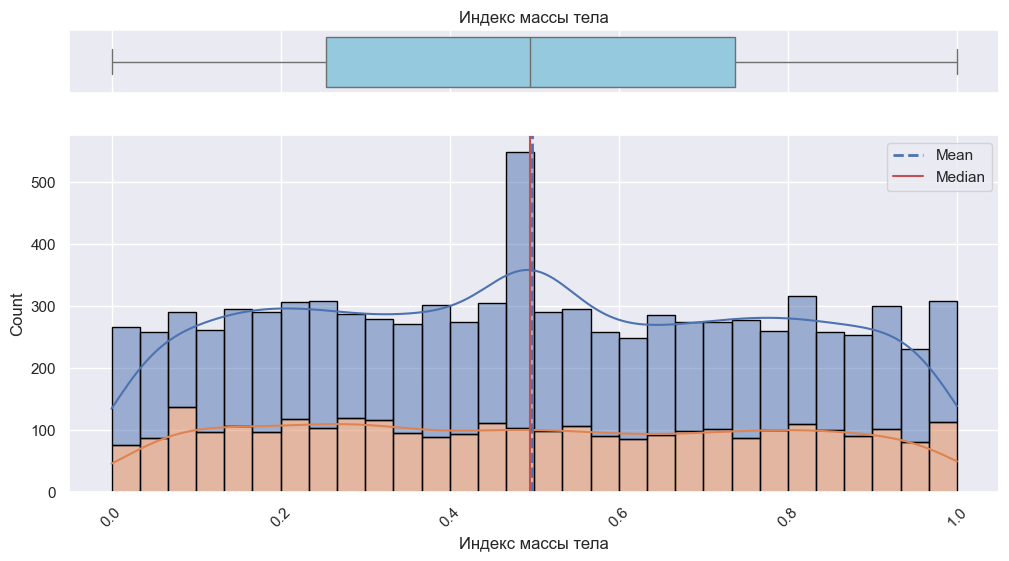

In [267]:
visualize_numerical_feature(df=train_df, 
                            feature='BMI', 
                            bins = 30, 
                            title='Индекс массы тела', 
                            xlabel='Индекс массы тела',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "BMI"**:
- Данные отмасштабированны;
- Для медианного значения индекса массы тела, наблюдается пик отсутствия сердечных приступов  - результат заполнения пропусков.

#### Количественный признак "Triglycerides"

Статистики для Triglycerides:
Уникальных значений: 772
Среднее: 0.51
Медиана: 0.50
Стандартное отклонение: 0.29
Минимум: 0.00
Максимум: 1.00
Q1: 0.26
Q3: 0.75
Количество выбросов: 0


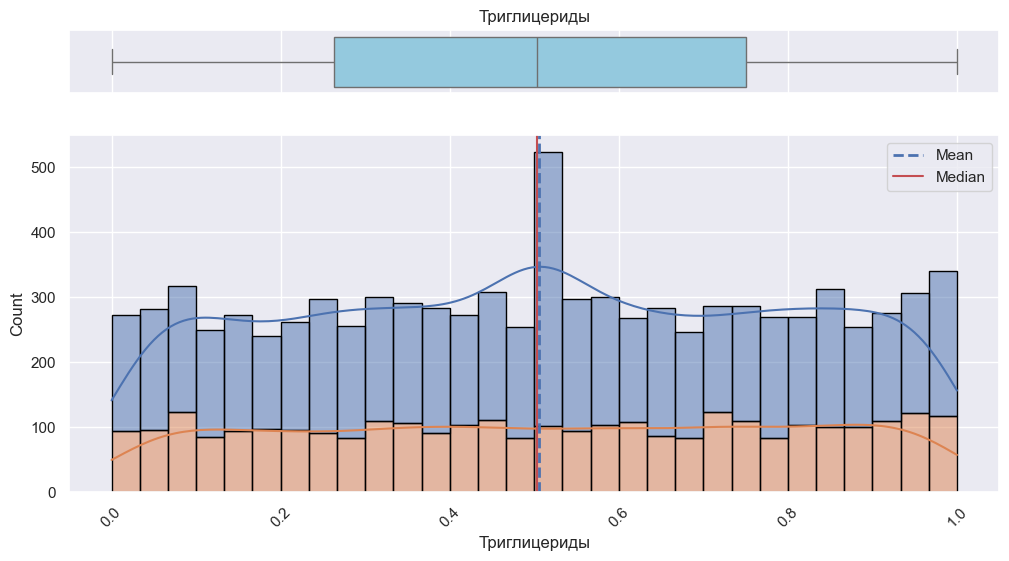

In [268]:
visualize_numerical_feature(df=train_df, 
                            feature='Triglycerides', 
                            bins = 30, 
                            title='Триглицериды', 
                            xlabel='Триглицериды',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Triglycerides"**:
- Данные отмасштабированны;
- Для медианного значения триглицеридов, наблюдается пик отсутствия сердечных приступов - результат заполнения пропусков.

#### Дискретный признак "Physical Activity Days Per Week"

Статистики для Physical Activity Days Per Week:
Уникальных значений: 8
Среднее: 3.49
Медиана: 3.00
Стандартное отклонение: 2.25
Минимум: 0.00
Максимум: 7.00


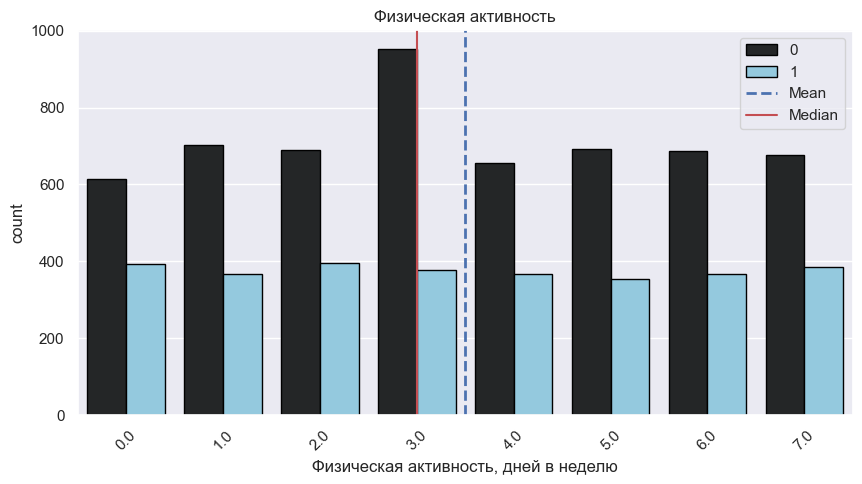

In [273]:
visualize_numerical_feature(df=train_df, 
                            feature='Physical Activity Days Per Week',
                            title='Физическая активность', 
                            xlabel='Физическая активность, дней в неделю',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Physical Activity Days Per Week"**:
- Для медианного значения физической активности = 3, наблюдается пик отсутствия сердечных приступов - результат заполнения пропусков.

#### Дискретный признак "Sleep Hours Per Day"

Статистики для Sleep Hours Per Day:
Уникальных значений: 8
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.33
Минимум: 0.00
Максимум: 1.00


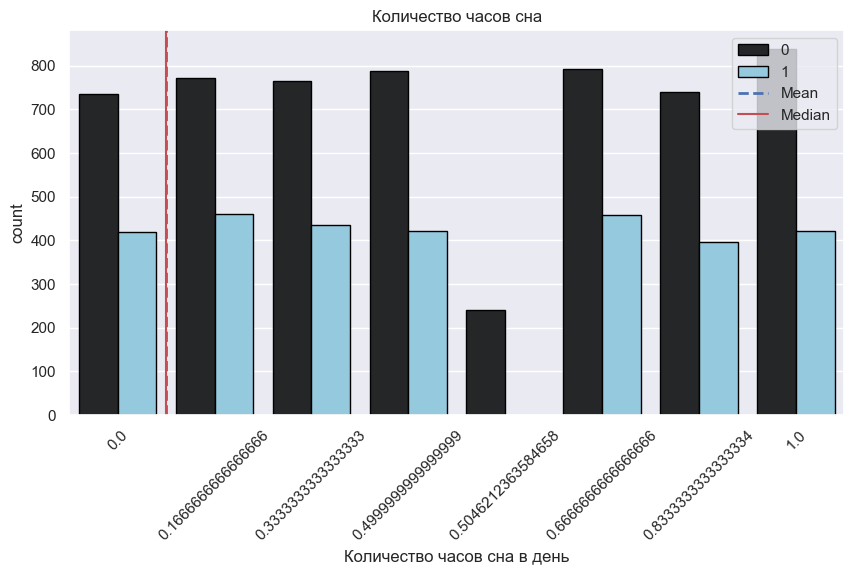

In [274]:
visualize_numerical_feature(df=train_df, 
                            feature='Sleep Hours Per Day',
                            title='Количество часов сна', 
                            xlabel='Количество часов сна в день',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Sleep Hours Per Day"**:
- Данные отмасштабированны;
- отсутсвуют данные по риску сердечного приступа для 0,5 часов сна

#### Количественный признак "Blood sugar"

Статистики для Blood sugar:
Уникальных значений: 239
Среднее: 0.23
Медиана: 0.23
Стандартное отклонение: 0.08
Минимум: 0.00
Максимум: 1.00
Q1: 0.23
Q3: 0.23
Количество выбросов: 2132


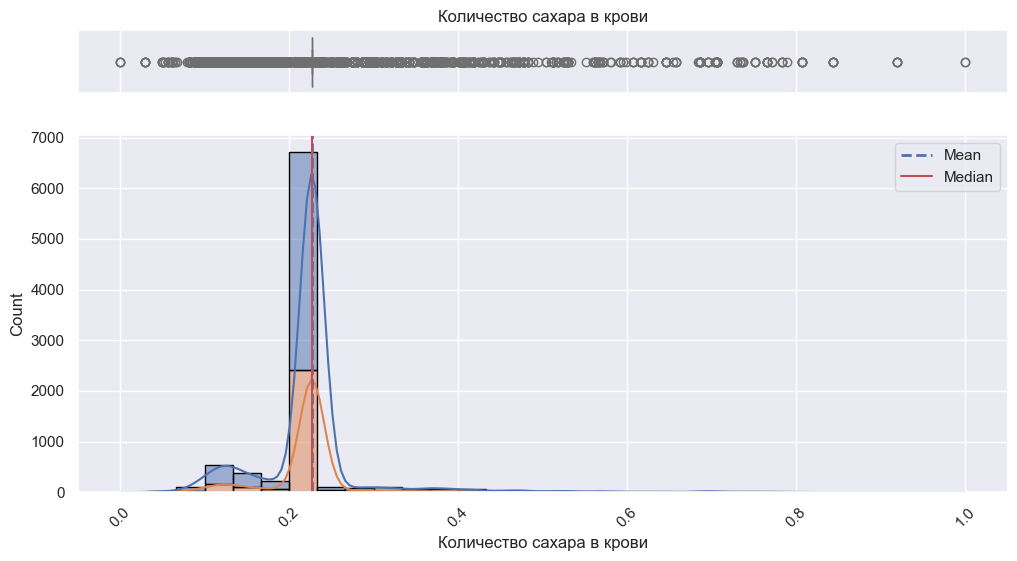

In [275]:
visualize_numerical_feature(df=train_df, 
                            feature='Blood sugar', 
                            bins = 30, 
                            title='Количество сахара в крови', 
                            xlabel='Количество сахара в крови',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Blood sugar"**:
- Данные отмасштабированны;
- Распределение имеет тяжелый хвост.

#### Количественный признак "CK-MB"

Статистики для CK-MB:
Уникальных значений: 678
Среднее: 0.05
Медиана: 0.05
Стандартное отклонение: 0.08
Минимум: 0.00
Максимум: 1.00
Q1: 0.05
Q3: 0.05
Количество выбросов: 2132


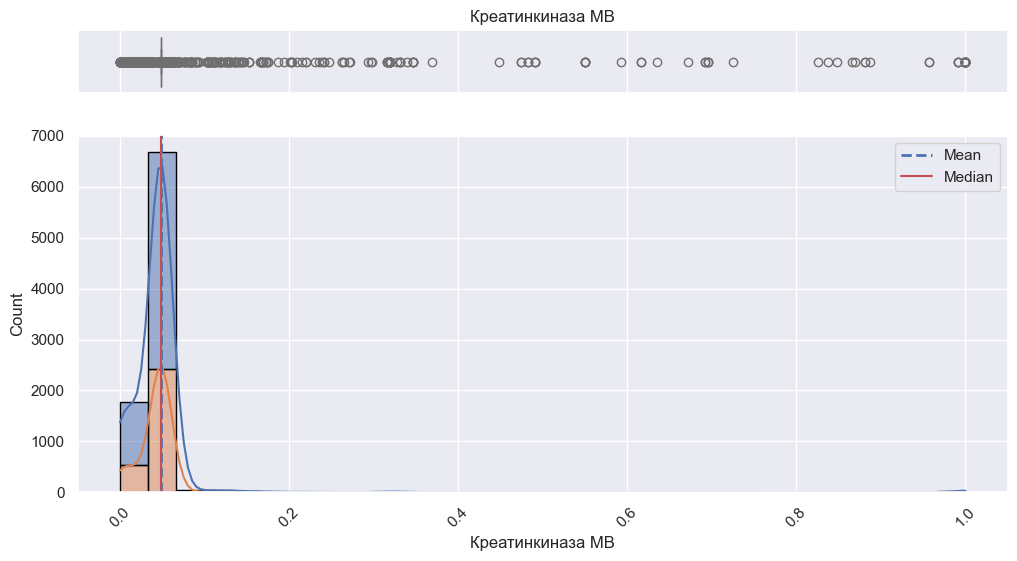

In [278]:
visualize_numerical_feature(df=train_df, 
                            feature='CK-MB', 
                            bins = 30, 
                            title='Креатинкиназа МВ', 
                            xlabel='Креатинкиназа МВ',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "CK-MB"**:
- Данные отмасштабированны;
- Распределение имеет тяжелый хвост.

#### Количественный признак "Troponin"

Статистики для Troponin:
Уникальных значений: 340
Среднее: 0.04
Медиана: 0.04
Стандартное отклонение: 0.06
Минимум: 0.00
Максимум: 1.00
Q1: 0.04
Q3: 0.04
Количество выбросов: 2132


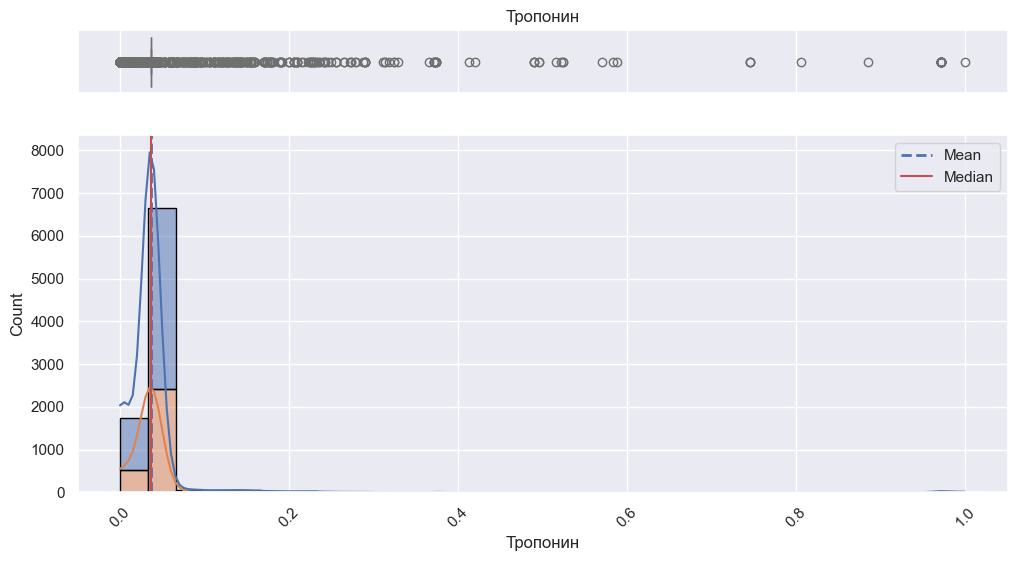

In [279]:
visualize_numerical_feature(df=train_df, 
                            feature='Troponin', 
                            bins = 30, 
                            title='Тропонин', 
                            xlabel='Тропонин',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Troponin"**:
- Данные отмасштабированны;
- Распределение имеет тяжелый хвост.

#### Количественный признак "Systolic blood pressure"

Статистики для Systolic blood pressure:
Уникальных значений: 100
Среднее: 0.45
Медиана: 0.45
Стандартное отклонение: 0.17
Минимум: 0.00
Максимум: 1.00
Q1: 0.30
Q3: 0.60
Количество выбросов: 0


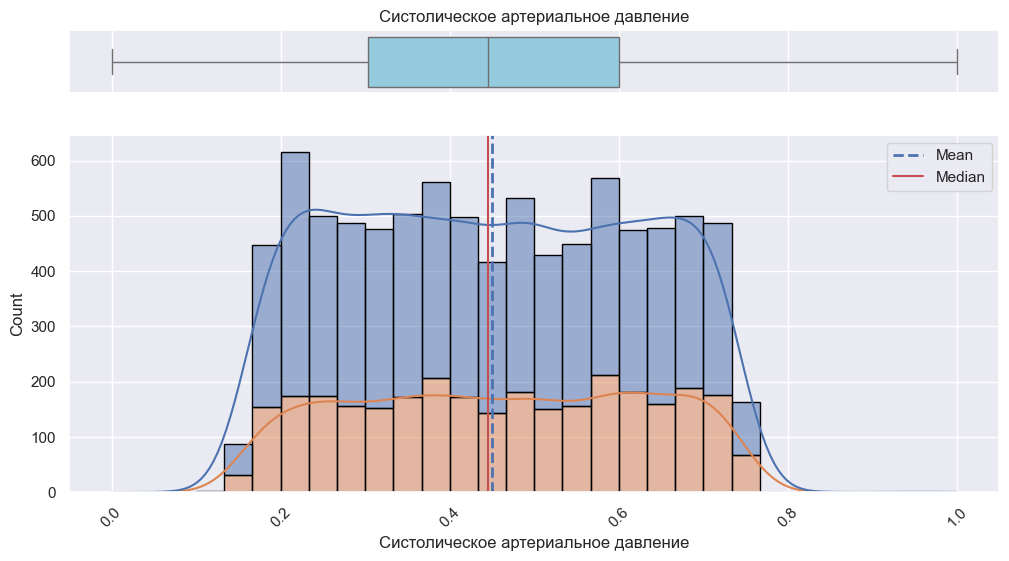

In [283]:
visualize_numerical_feature(df=train_df, 
                            feature='Systolic blood pressure', 
                            bins = 30, 
                            title='Систолическое артериальное давление', 
                            xlabel='Систолическое артериальное давление',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Systolic blood pressure"**:
- Данные отмасштабированны;

#### Количественный признак "Diastolic blood pressure"

Статистики для Diastolic blood pressure:
Уникальных значений: 66
Среднее: 0.50
Медиана: 0.50
Стандартное отклонение: 0.17
Минимум: 0.00
Максимум: 1.00
Q1: 0.35
Q3: 0.65
Количество выбросов: 0


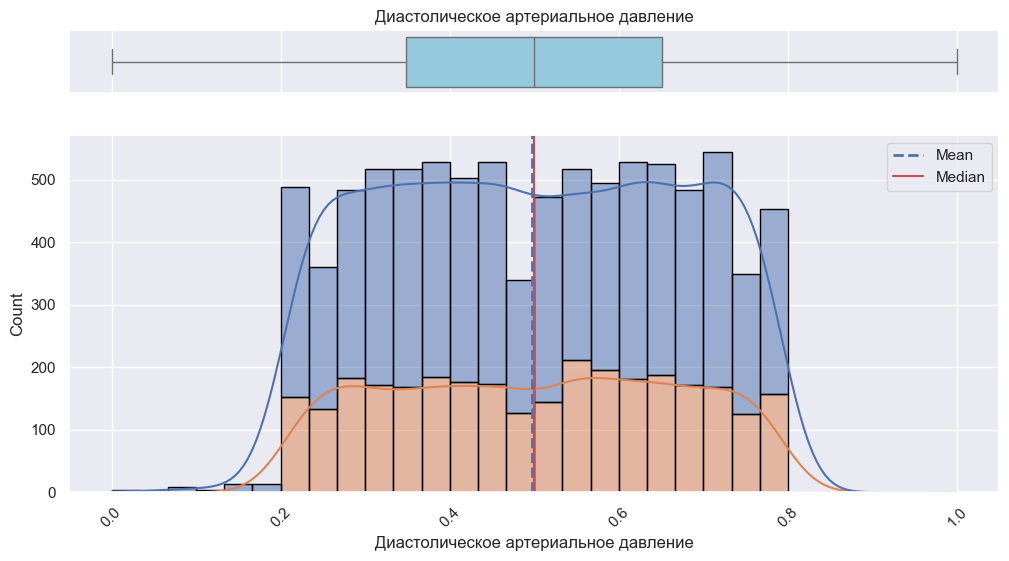

In [284]:
visualize_numerical_feature(df=train_df, 
                            feature='Diastolic blood pressure', 
                            bins = 30, 
                            title='Диастолическое артериальное давление', 
                            xlabel='Диастолическое артериальное давление',
                            hue='Heart Attack Risk (Binary)'
                           )

Вывод по подразделу **Количественный признак "Diastolic blood pressure"**:
- Данные отмасштабированны;

### Категориальный признак "Diabetes"

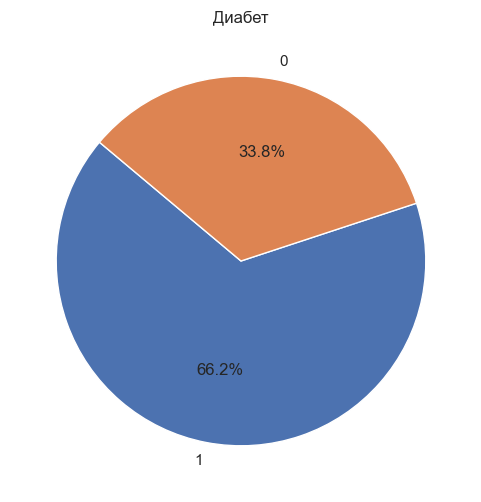

Статистика для Diabetes:
- Уникальные значения: 2

- Мода: 1

- Частота по категориям:
Diabetes
1    5746
0    2937
Name: count, dtype: int64

- Процентное соотношение:
Diabetes
1   66.00
0   34.00
Name: proportion, dtype: float64


In [285]:
visualize_categorical_feature(df=train_df, 
                              feature='Diabetes',
                             title='Диабет')

### Категориальный признак "Family History"

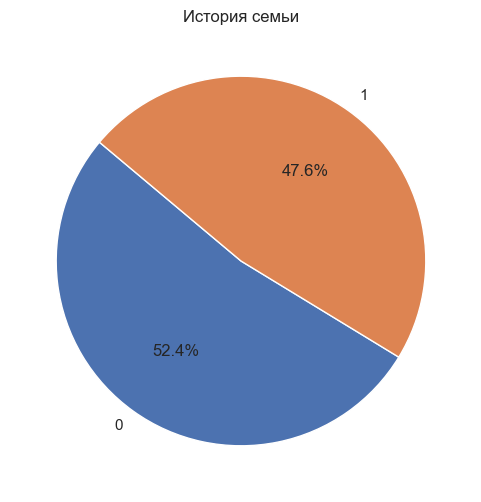

Статистика для Family History:
- Уникальные значения: 2

- Мода: 0

- Частота по категориям:
Family History
0    4550
1    4133
Name: count, dtype: int64

- Процентное соотношение:
Family History
0   52.00
1   48.00
Name: proportion, dtype: float64


In [286]:
visualize_categorical_feature(df=train_df, 
                              feature='Family History',
                             title='История семьи')

### Категориальный признак "Smoking"

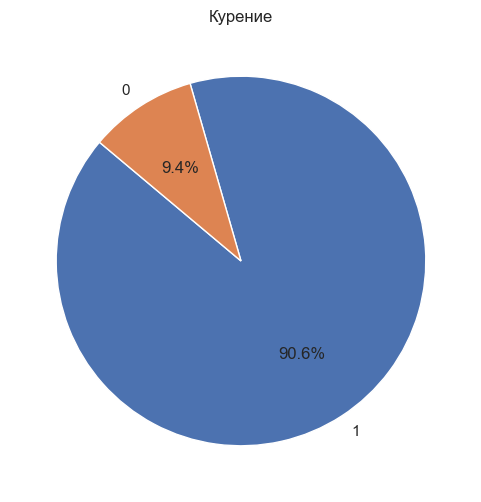

Статистика для Smoking:
- Уникальные значения: 2

- Мода: 1

- Частота по категориям:
Smoking
1    7863
0     820
Name: count, dtype: int64

- Процентное соотношение:
Smoking
1   91.00
0    9.00
Name: proportion, dtype: float64


In [287]:
visualize_categorical_feature(df=train_df, 
                              feature='Smoking',
                             title='Курение')

### Категориальный признак "Obesity"

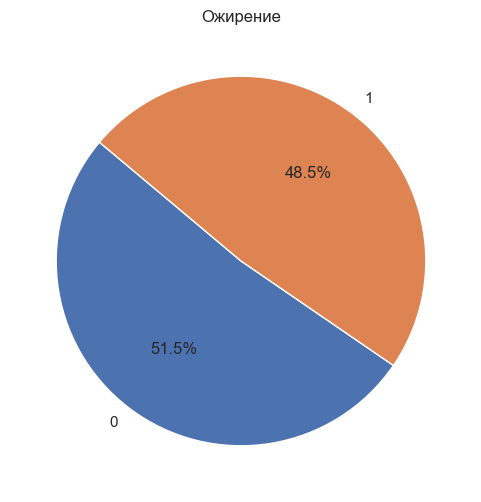

Статистика для Obesity:
- Уникальные значения: 2

- Мода: 0

- Частота по категориям:
Obesity
0    4476
1    4207
Name: count, dtype: int64

- Процентное соотношение:
Obesity
0   52.00
1   48.00
Name: proportion, dtype: float64


In [288]:
visualize_categorical_feature(df=train_df, 
                              feature='Obesity',
                             title='Ожирение')

### Категориальный признак "Alcohol Consumption"

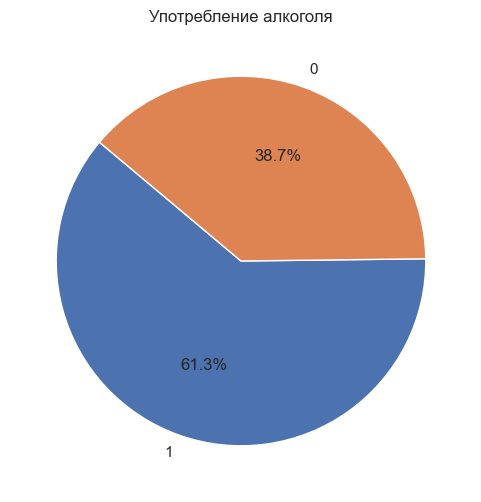

Статистика для Alcohol Consumption:
- Уникальные значения: 2

- Мода: 1

- Частота по категориям:
Alcohol Consumption
1    5323
0    3360
Name: count, dtype: int64

- Процентное соотношение:
Alcohol Consumption
1   61.00
0   39.00
Name: proportion, dtype: float64


In [289]:
visualize_categorical_feature(df=train_df, 
                              feature='Alcohol Consumption',
                             title='Употребление алкоголя')

### Категориальный признак "Diet"

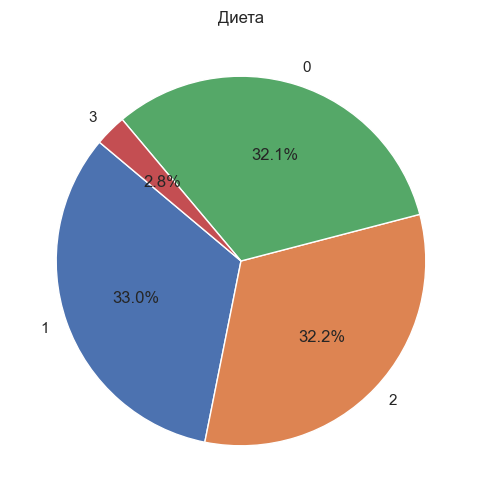

Статистика для Diet:
- Уникальные значения: 4

- Мода: 1

- Частота по категориям:
Diet
1    2863
2    2796
0    2783
3     241
Name: count, dtype: int64

- Процентное соотношение:
Diet
1   33.00
2   32.00
0   32.00
3    3.00
Name: proportion, dtype: float64


In [290]:
visualize_categorical_feature(df=train_df, 
                              feature='Diet',
                             title='Диета')

### Категориальный признак "Previous Heart Problems"

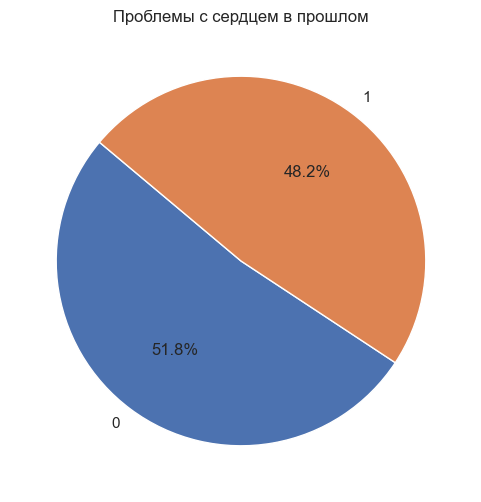

Статистика для Previous Heart Problems:
- Уникальные значения: 2

- Мода: 0

- Частота по категориям:
Previous Heart Problems
0    4501
1    4182
Name: count, dtype: int64

- Процентное соотношение:
Previous Heart Problems
0   52.00
1   48.00
Name: proportion, dtype: float64


In [291]:
visualize_categorical_feature(df=train_df, 
                              feature='Previous Heart Problems',
                             title='Проблемы с сердцем в прошлом')

### Категориальный признак "Medication Use"

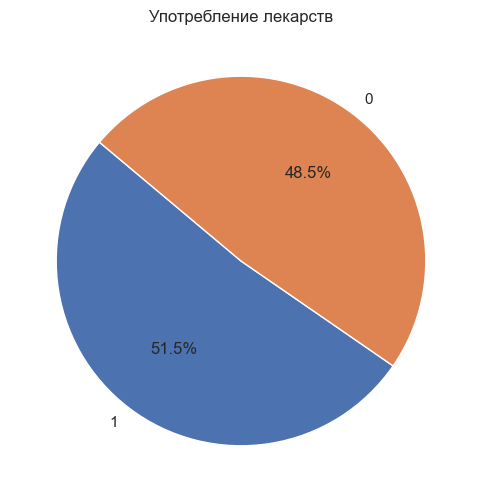

Статистика для Medication Use:
- Уникальные значения: 2

- Мода: 1

- Частота по категориям:
Medication Use
1    4472
0    4211
Name: count, dtype: int64

- Процентное соотношение:
Medication Use
1   52.00
0   48.00
Name: proportion, dtype: float64


In [292]:
visualize_categorical_feature(df=train_df, 
                              feature='Medication Use',
                             title='Употребление лекарств')

### Категориальный признак "Gender"

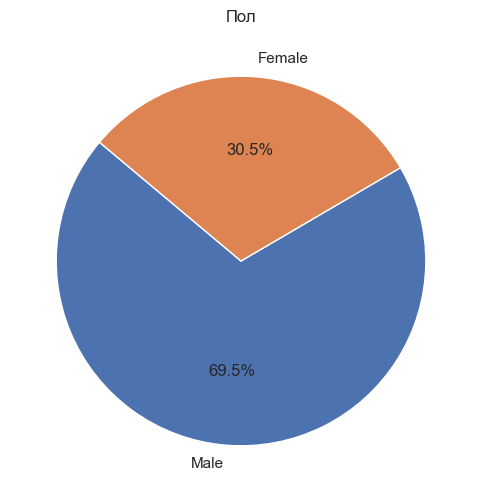

Статистика для Gender:
- Уникальные значения: 2

- Мода: Male

- Частота по категориям:
Gender
Male      6038
Female    2645
Name: count, dtype: int64

- Процентное соотношение:
Gender
Male     70.00
Female   30.00
Name: proportion, dtype: float64


In [293]:
visualize_categorical_feature(df=train_df, 
                              feature='Gender',
                             title='Пол')

### Категориальный признак "Heart Attack Risk (Binary)"

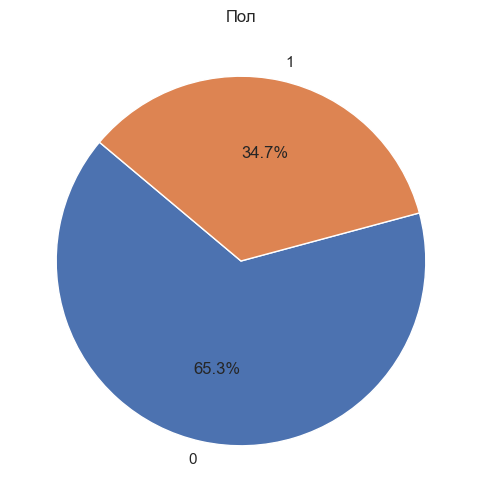

Статистика для Heart Attack Risk (Binary):
- Уникальные значения: 2

- Мода: 0

- Частота по категориям:
Heart Attack Risk (Binary)
0    5670
1    3013
Name: count, dtype: int64

- Процентное соотношение:
Heart Attack Risk (Binary)
0   65.00
1   35.00
Name: proportion, dtype: float64


In [294]:
visualize_categorical_feature(df=train_df, 
                              feature='Heart Attack Risk (Binary)',
                             title='Пол')

Вывод по разделу **"Иследование данных"**:
- Данные имеют плохое качество.